In [1]:
import pandas as pd

In [2]:
path = '../CPI_MR_2008.xlsx'    

df = pd.read_excel(path, index_col=0, parse_dates=True)
df

,CPI,MR
date,,
2007-06-01,2.630579,6.475
2007-06-07,2.611391,6.530
...,...,...
2009-05-28,2.129682,4.910
2009-06-01,2.089895,5.100


In [3]:
dates = ["2007-06-01", "2008-01-01", "2008-09-01", "2010-01-01"]
dates = pd.to_datetime(dates)

periods = pd.cut(
    df.index, bins=dates, labels=["Before", "During", "After"], right=False
)

df["period"] = periods
df

,CPI,MR,period
date,,,
2007-06-01,2.630579,6.475,Before
2007-06-07,2.611391,6.530,Before
...,...,...,...
2009-05-28,2.129682,4.910,After
2009-06-01,2.089895,5.100,After


In [4]:
df.to_parquet(path.replace('.xlsx', '.parquet'))

In [ ]:
df.query('period == "After"').drop(columns=['period']).to_parquet(path.replace('.xlsx', '_after.parquet'))

In [4]:
import numpy as np
import ruptures as rpt

X = df[['CPI']]
y = df['MR']

signal = np.column_stack([X, y])  # shape: (n_samples, 2)

In [5]:
algo = rpt.Pelt(model="linear").fit(signal)

In [6]:
dfs = {}

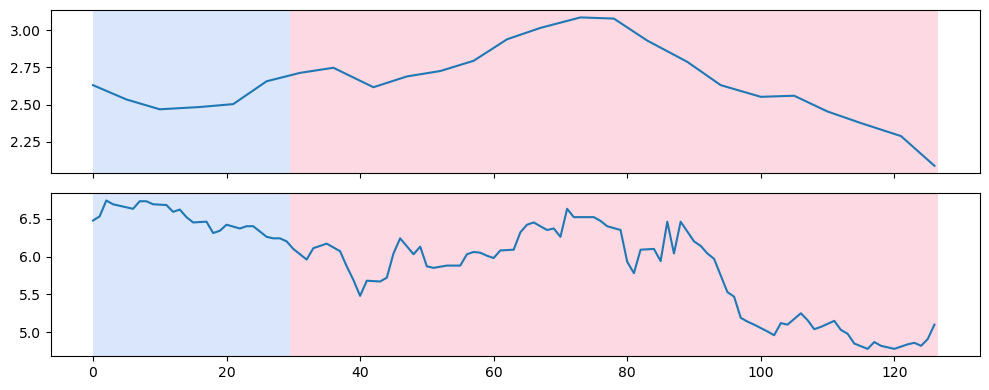

In [7]:
def detect_and_display_breakpoints(algo, signal, pen=1):
    breakpoints = algo.predict(pen=pen)
    rpt.display(signal, breakpoints)

detect_and_display_breakpoints(algo, signal)

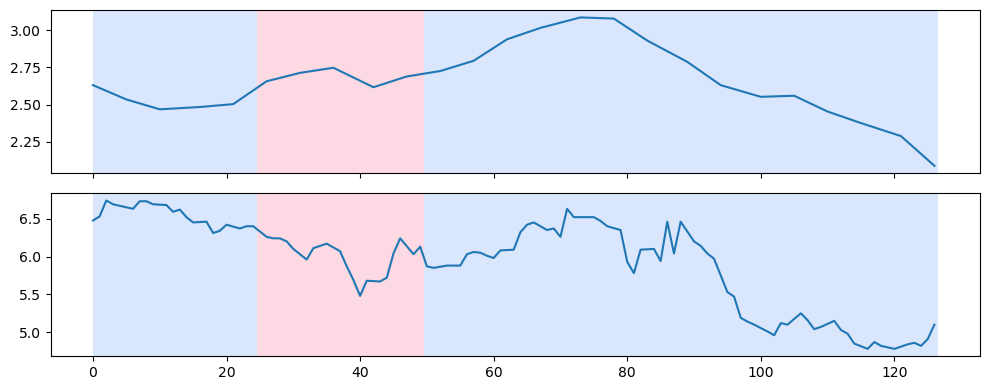

In [8]:
detect_and_display_breakpoints(algo, signal, pen=0.2)

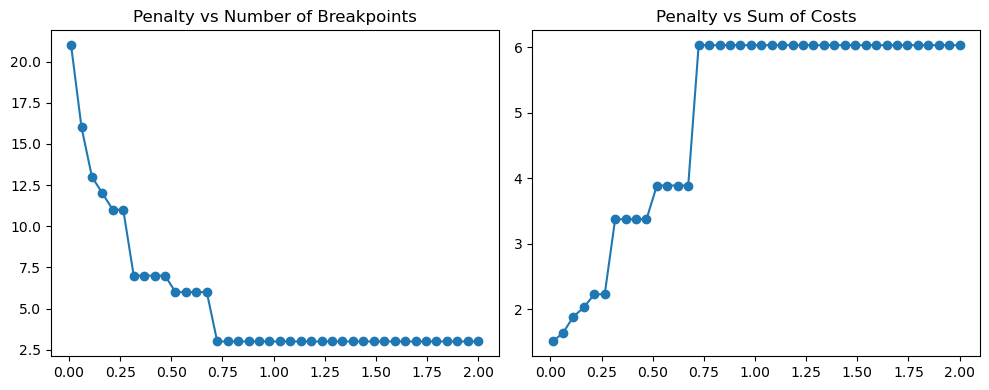

In [9]:
import ruptures as rpt
import numpy as np
import matplotlib.pyplot as plt

signal = df[["MR", "CPI"]].dropna().values
penalties = np.linspace(0.01, 2, 40)  # adjust as needed
n_bkps = []
costs = []

for pen in penalties:
    algo = rpt.Pelt(model="linear").fit(signal)
    bkps = algo.predict(pen=pen)
    n_bkps.append(len(bkps))
    costs.append(algo.cost.sum_of_costs(bkps))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(penalties, n_bkps, marker="o")
plt.title("Penalty vs Number of Breakpoints")

plt.subplot(1, 2, 2)
plt.plot(penalties, costs, marker="o")
plt.title("Penalty vs Sum of Costs")
plt.tight_layout()
plt.show()

(<Figure size 1000x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

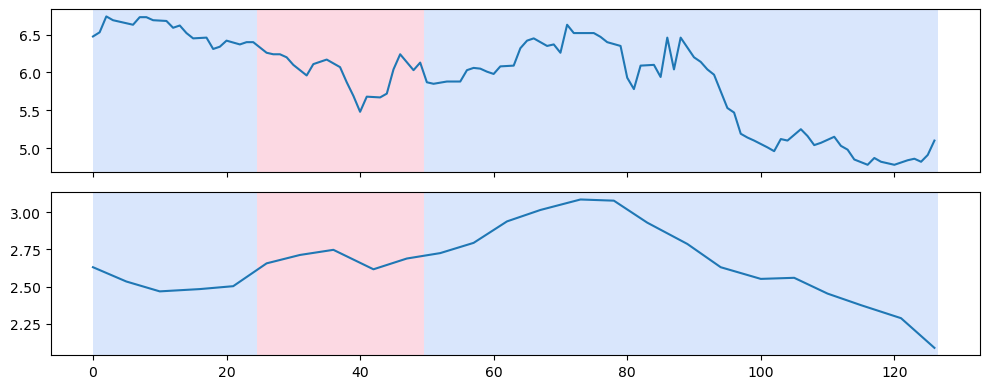

In [10]:
breakpoints = algo.predict(pen=0.72)
rpt.display(signal, breakpoints)

In [11]:
df["Period"] = None

start = 0
for label, bp in enumerate(breakpoints):
    df.iloc[start:bp, df.columns.get_loc("Period")] = label
    start = bp


In [12]:
r = df.reset_index().groupby("Period").date.agg(["min", "max"])


In [13]:
dfs['algo'] = r

In [14]:
import plotly.express as px

fig = px.scatter(
    df.reset_index(),
    x="MR",
    y="CPI",
    color="Period",
    trendline="ols",
    facet_col="Period",
)
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)


In [18]:
df.query('Period == 2').drop(columns=['Period']).to_parquet('../../FRED/cpi_mr_2008_after.parquet')

In [15]:
df

,min,max
Period,,
0,2007-06-01,2007-10-18
1,2007-10-25,2008-03-13
2,2008-03-20,2009-06-01


In [16]:
df = pd.read_excel('../CPI_MR_2008.xlsx', index_col=0, parse_dates=True)

In [17]:
dates = ["2007-06-01", "2008-01-01", "2008-09-01", "2010-01-01"]
dates = pd.to_datetime(dates)

periods = pd.cut(
    df.index, bins=dates, labels=["Before", "During", "After"], right=False
)

df["Period"] = periods
df


,CPI,MR,Period
date,,,
2007-06-01,2.630579,6.475,Before
2007-06-07,2.611391,6.530,Before
...,...,...,...
2009-05-28,2.129682,4.910,After
2009-06-01,2.089895,5.100,After


In [18]:
dfr = df.reset_index().groupby('Period').date.agg(['min', 'max'])

/var/folders/89/hqh4vvhn24q2xc8ph93krqz80000gn/T/ipykernel_41705/2248642362.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfr = df.reset_index().groupby('Period').date.agg(['min', 'max'])


In [19]:
dfs['eye'] = dfr

In [22]:
dfs['eye'].index = [0,1,2]

In [23]:
pd.concat(dfs, axis=1)

algo                   eye           
         min        max        min        max
0 2007-06-01 2007-10-18 2007-06-01 2007-12-27
1 2007-10-25 2008-03-13 2008-01-01 2008-08-28
2 2008-03-20 2009-06-01 2008-09-01 2009-06-01

In [ ]:
1. Use

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


def segment_cost(df, breakpoints, x_col, y_col, metric="r2"):
    start = 0
    scores = []

    for bp in breakpoints:
        segment = df.iloc[start:bp]
        x = segment[[x_col]].values
        y = segment[y_col].values
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)

        if metric == "r2":
            score = r2_score(y, y_pred)
        elif metric == "mse":
            score = mean_squared_error(y, y_pred)
        else:
            raise ValueError("Unsupported metric")

        scores.append(score)
        start = bp

    return scores


In [66]:
# assume breakpoints = [50, 100, len(df)]
segment_cost(df, breakpoints, x_col="MR", y_col="CPI", metric="r2")

[0.001080319963378762,
 0.1415287687288289,
 0.6821591358652321,
 0.2829007020647454,
 0.6581888305328909,
 1.0]

In [67]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import ruptures as rpt


def evaluate_penalty(signal, df, penalties, x_col, y_col):
    best_pen = None
    best_score = -np.inf
    score_by_penalty = []

    for pen in penalties:
        algo = rpt.Pelt(model="linear").fit(signal)
        breakpoints = algo.predict(pen=pen)
        start = 0
        r2s = []

        for bp in breakpoints:
            segment = df.iloc[start:bp]
            x = segment[[x_col]].values
            y = segment[y_col].values

            if len(segment) < 3:
                r2s.append(-np.inf)  # penalize too-small segments
            else:
                model = LinearRegression().fit(x, y)
                y_pred = model.predict(x)
                r2 = r2_score(y, y_pred)
                r2s.append(r2)

            start = bp

        avg_r2 = np.mean(r2s)
        score_by_penalty.append((pen, avg_r2))

        if avg_r2 > best_score:
            best_score = avg_r2
            best_pen = pen

    return best_pen, score_by_penalty


In [71]:
signal = df[["MR", "CPI"]].dropna().values
penalties = np.linspace(0.01, 2.0, 40)

best_penalty, all_scores = evaluate_penalty(
    signal, df, penalties, "MR", "CPI"
)


In [72]:
best_penalty

np.float64(0.7243589743589745)

In [73]:
all_scores

[(np.float64(0.01), np.float64(-inf)),
 (np.float64(0.06102564102564103), np.float64(-inf)),
 (np.float64(0.11205128205128205), np.float64(-inf)),
 (np.float64(0.1630769230769231), np.float64(-inf)),
 (np.float64(0.21410256410256412), np.float64(-inf)),
 (np.float64(0.2651282051282051), np.float64(-inf)),
 (np.float64(0.3161538461538462), np.float64(-inf)),
 (np.float64(0.36717948717948723), np.float64(-inf)),
 (np.float64(0.41820512820512823), np.float64(-inf)),
 (np.float64(0.46923076923076923), np.float64(-inf)),
 (np.float64(0.5202564102564102), np.float64(-inf)),
 (np.float64(0.5712820512820513), np.float64(-inf)),
 (np.float64(0.6223076923076923), np.float64(-inf)),
 (np.float64(0.6733333333333333), np.float64(-inf)),
 (np.float64(0.7243589743589745), np.float64(0.33377768286879245)),
 (np.float64(0.7753846153846154), np.float64(0.33377768286879245)),
 (np.float64(0.8264102564102564), np.float64(0.33377768286879245)),
 (np.float64(0.8774358974358974), np.float64(0.333777682868792

In [43]:
algo = rpt.Binseg(model="linear").fit(signal)
breakpoints = algo.predict(n_bkps=4)  # specify number of breakpoints

(<Figure size 1000x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

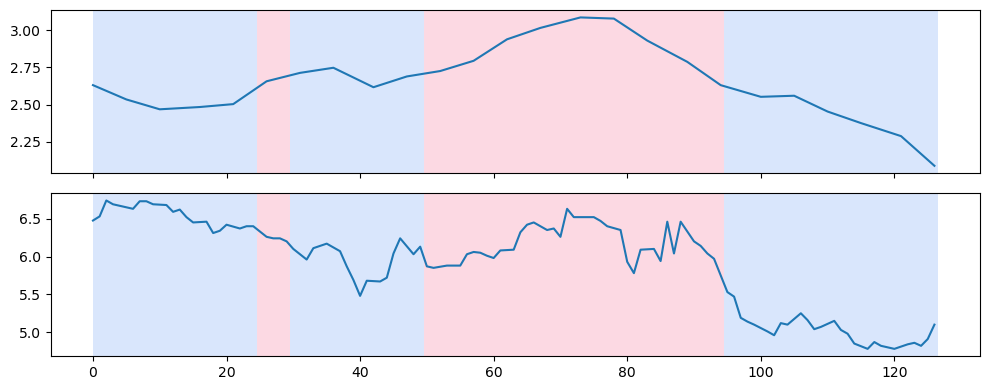

In [44]:
rpt.display(signal, breakpoints)

In [36]:
breakpoints

[25, 30, 50, 95, 120, 127]

In [10]:
mamba install ruptures


Looking for: ['ruptures']

[+] 0.0s
[+] 0.1s
conda-forge/osx-arm64 ━━━━━╸━━━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
conda-forge/noarch    ━━━━━━━━╸━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s[+] 0.2s
conda-forge/osx-arm64 ━━━━━━━╸━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.2s
conda-forge/noarch    ━━━━━━━━━━━━━━━━━━━━━━  12.9kB /  20.0MB @  67.4kB/s  0.2s[+] 0.3s
conda-forge/osx-arm64 ━━━━━━━━━╸━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.3s
conda-forge/noarch    ━╸━━━━━━━━━━━━━━━━━━━━   2.2MB /  20.0MB @   7.3MB/s  0.3s[+] 0.4s
conda-forge/osx-arm64 ━━━━━━━━━━╸━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.4s
conda-forge/noarch    ━━━╸━━━━━━━━━━━━━━━━━━   4.2MB /  20.0MB @  11.1MB/s  0.4s[+] 0.5s
conda-forge/osx-arm64 ━━━━━━━━━━━━━━━━━━━━━━  44.6kB /  15.4MB @  94.1kB/s  0.5s
conda-forge/noarch    ━━━━━━━━╸━━━━━━━━━━━━━   8.3MB /  20.0MB @  17.4MB/s  0.5s[+] 0.6s
conda-forge/osx-arm64 ━━━━━━━━━━━━━━━━━━━━━━ 193.3kB /  15.4MB @ 326.6kB/s  0.6s
conda-forge/noarch    ━

In [ ]:
import ruptures as rpt

X = df.reset_index()[["date", "mortgage_rate", "CPI"]].copy()
X["date"] = X["date"].astype("int64") // 1e9  # convert to seconds

signal = X.values  # multivariate signal
algo = rpt.Pelt(model="linear").fit(signal)
breakpoints = algo.predict(pen=10)

In [45]:
import plotly.express as px

fig = px.scatter(df.reset_index(), x="MR", y="CPI", color="Period", trendline="ols", facet_col="Period")
fig.update_xaxes(matches=None)
fig.update_yaxes(matches=None)